In [1]:
import numpy as np
import pandas as pd
import os
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import cv2
from sklearn.model_selection import GridSearchCV


dataset = pd.read_csv("leaves_dataset_aug.csv")
dataset.head(5)

X = dataset.iloc[:,2:]

y = dataset['species']
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 135)
X_train.head(5)


#skaliranje
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


In [2]:
import mahotas as mt
import re
import matplotlib
import matplotlib.pyplot as plt

In [3]:
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
             ]
svm_clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters)
svm_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [4]:
svm_clf.best_params_

{'C': 100, 'kernel': 'linear'}

In [5]:
clf = svm.SVC(C=100.0, decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',)
clf.fit(X_train,y_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.9928571428571429

In [8]:
def preprocess_leaf(image):
    names = ['area','perimeter','pysiological_length','pysiological_width','aspect_ratio','rectangularity','circularity', \
        'mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b', \
        'contrast','correlation','inverse_difference_moments','entropy'
      ]
    df = pd.DataFrame([], columns=names)
    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (55,55),0)
    ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8) 
    closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel) #mask
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len(contours)

    cnt = contours[0]
    len(cnt)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)

    #species = find_species(file) #prima naziv photografije "file"
    #Shape features
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h
    rectangularity = w*h/area
    circularity = ((perimeter)**2)/area


    #Color features
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    blue_channel[blue_channel == 255] = 0
    green_channel[green_channel == 255] = 0
    red_channel[red_channel == 255] = 0

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)

    red_std = np.std(red_channel) 
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)

    #Texture features
    textures = mt.features.haralick(gray)
    ht_mean = textures.mean(axis=0)
    contrast = ht_mean[1]
    correlation = ht_mean[2]
    inverse_diff_moments = ht_mean[4]
    entropy = ht_mean[8]

    vector = [area,perimeter,w,h,aspect_ratio,rectangularity,circularity,\
      red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
      contrast,correlation,inverse_diff_moments,entropy]
    df_temp = pd.DataFrame([vector],columns=names)
    df = df.append(df_temp)
    return df

In [9]:
def find_output(classes):
    return max(set(classes), key = classes.count)

def calculate_percent(classes, class_index):
    result = classes.count(class_index)*100.0/len(classes)
    return result

def get_name(class_index):
    common_names = ['pubescent bamboo','Chinese horse chestnut','Anhui Barberry', \
                'Chinese redbud','true indigo','Japanese maple','Nanmu',' castor aralia', \
                'Chinese cinnamon','goldenrain tree','Big-fruited Holly','Japanese cheesewood', \
                'wintersweet','camphortree','Japan Arrowwood','sweet osmanthus','deodar','ginkgo, maidenhair tree', \
                'Crape myrtle, Crepe myrtle','oleander','yew plum pine','Japanese Flowering Cherry','Glossy Privet',\
                'Chinese Toon','peach','Ford Woodlotus','trident maple','Beales barberry','southern magnolia',\
                'Canadian poplar','Chinese tulip tree','tangerine'
               ]
    return common_names[class_index]

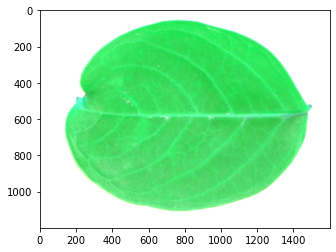

        area    perimeter pysiological_length pysiological_width  \
0  1066269.0  3988.786254                1344               1044   

   aspect_ratio  rectangularity  circularity     mean_r      mean_g  \
0      1.287356        1.315931    14.921578  39.706393  125.098071   

      mean_b   stddev_r    stddev_g   stddev_b  contrast  correlation  \
0  60.542029  40.013291  111.887105  55.305443  3.559969     0.999025   

   inverse_difference_moments   entropy  
0                    0.682749  6.034127  
[18] Crape myrtle, Crepe myrtle


In [12]:
#prepoznavanje lista kada na slici ima jedan list
img = cv2.imread("Leaves/test/2515.jpg")
plt.imshow(img)
plt.show()
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
classes = []

leaf_features = preprocess_leaf(original_img)
print(leaf_features)

X_test = sc_X.transform(leaf_features)
y_pred = clf.predict(X_test)
print(y_pred, get_name(y_pred[0]))

In [13]:
breakpoints = [1001,1059,1060,1122,1552,1616,1123,1194,
               1195,1267,1268,1323,1324,1385,1386,1437,
               1497,1551,1438,1496,2001,2050,2051,2113,
               2114,2165,2166,2230,2231,2290,2291,2346,
               2347,2423,2424,2485,2486,2546,2547,2612,
               2616,2675,3001,3055,3056,3110,3111,3175,
               3176,3229,3230,3281,3282,3334,3335,3389,
               3390,3446,3447,3510,3511,3563,3566,3621]

def find_species(file):
    target_num = int(file.split(".")[0])
    flag = 0
    i = 0 
    for i in range(0,len(breakpoints),2):
        if((target_num >= breakpoints[i]) and (target_num <= breakpoints[i+1])):
            flag = 1
            break
    if(flag==1):
        target = int((i/2))
        return target # vraca redni br vrste [0,1...,31]

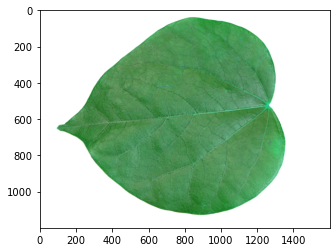

Predicted result:
[3] Chinese redbud
Expected result:
Chinese redbud
Plant is recognized correctly!


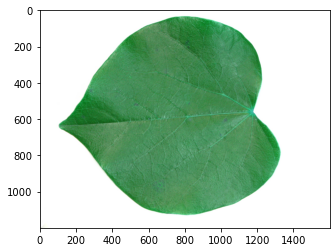

Predicted result:
[3] Chinese redbud
Expected result:
Chinese redbud
Plant is recognized correctly!


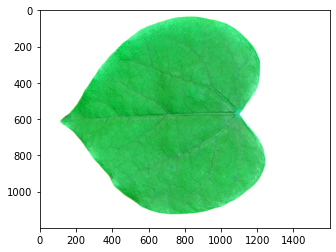

Predicted result:
[3] Chinese redbud
Expected result:
Chinese redbud
Plant is recognized correctly!


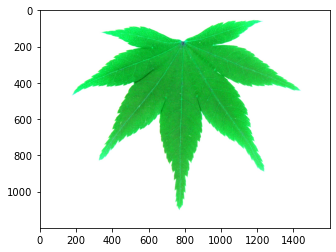

Predicted result:
[5] Japanese maple
Expected result:
Japanese maple
Plant is recognized correctly!


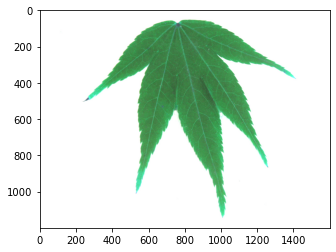

Predicted result:
[5] Japanese maple
Expected result:
Japanese maple
Plant is recognized correctly!


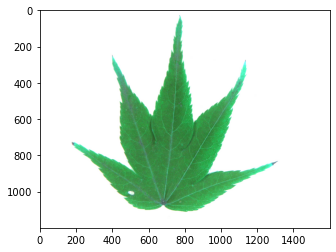

Predicted result:
[5] Japanese maple
Expected result:
Japanese maple
Plant is recognized correctly!


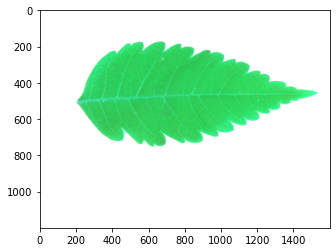

Predicted result:
[9] goldenrain tree
Expected result:
goldenrain tree
Plant is recognized correctly!


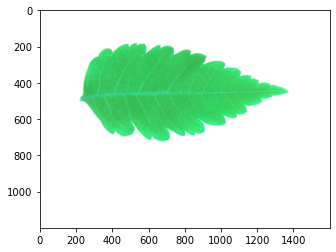

Predicted result:
[9] goldenrain tree
Expected result:
goldenrain tree
Plant is recognized correctly!


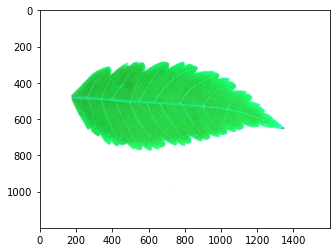

Predicted result:
[9] goldenrain tree
Expected result:
goldenrain tree
Plant is recognized correctly!


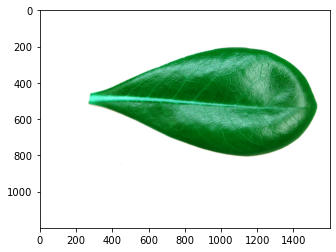

Predicted result:
[11] Japanese cheesewood
Expected result:
Japanese cheesewood
Plant is recognized correctly!


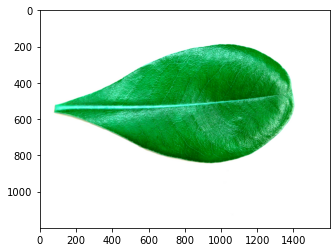

Predicted result:
[11] Japanese cheesewood
Expected result:
Japanese cheesewood
Plant is recognized correctly!


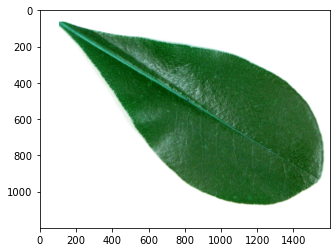

Predicted result:
[11] Japanese cheesewood
Expected result:
Japanese cheesewood
Plant is recognized correctly!


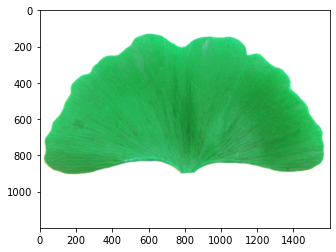

Predicted result:
[3] Chinese redbud
Expected result:
ginkgo, maidenhair tree
Plant is not recognized correctly!


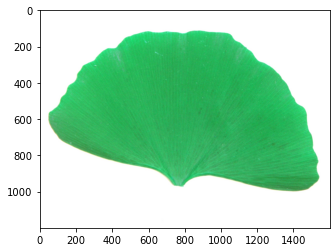

Predicted result:
[3] Chinese redbud
Expected result:
ginkgo, maidenhair tree
Plant is not recognized correctly!


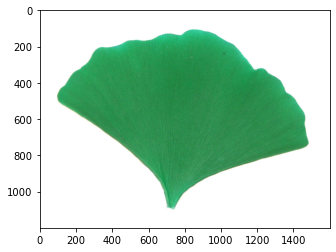

Predicted result:
[3] Chinese redbud
Expected result:
ginkgo, maidenhair tree
Plant is not recognized correctly!


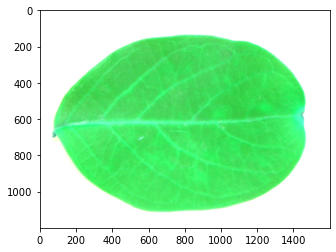

Predicted result:
[18] Crape myrtle, Crepe myrtle
Expected result:
Crape myrtle, Crepe myrtle
Plant is recognized correctly!


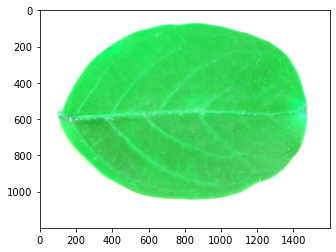

Predicted result:
[18] Crape myrtle, Crepe myrtle
Expected result:
Crape myrtle, Crepe myrtle
Plant is recognized correctly!


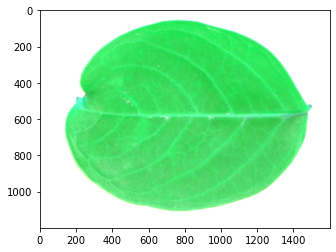

Predicted result:
[18] Crape myrtle, Crepe myrtle
Expected result:
Crape myrtle, Crepe myrtle
Plant is recognized correctly!


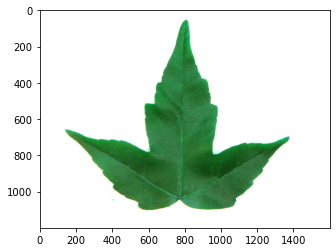

Predicted result:
[26] trident maple
Expected result:
trident maple
Plant is recognized correctly!


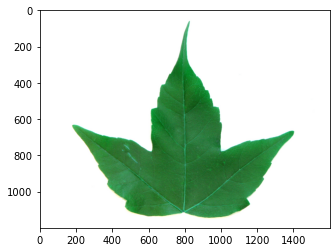

Predicted result:
[26] trident maple
Expected result:
trident maple
Plant is recognized correctly!


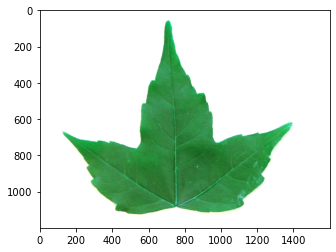

Predicted result:
[26] trident maple
Expected result:
trident maple
Plant is recognized correctly!


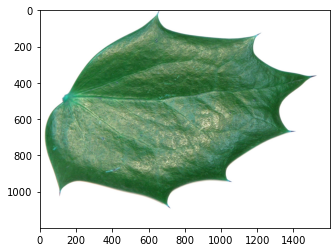

Predicted result:
[27] Beales barberry
Expected result:
Beales barberry
Plant is recognized correctly!


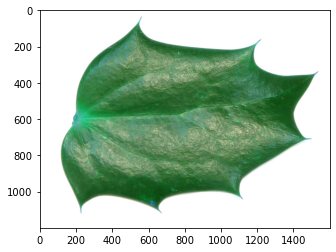

Predicted result:
[27] Beales barberry
Expected result:
Beales barberry
Plant is recognized correctly!


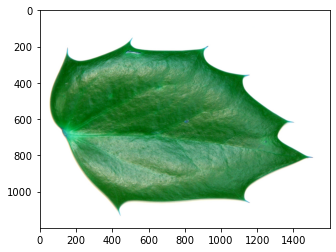

Predicted result:
[27] Beales barberry
Expected result:
Beales barberry
Plant is recognized correctly!


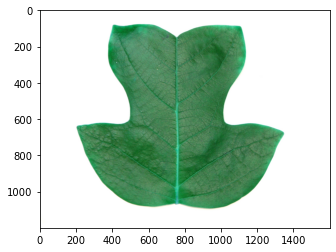

Predicted result:
[26] trident maple
Expected result:
Chinese tulip tree
Plant is not recognized correctly!


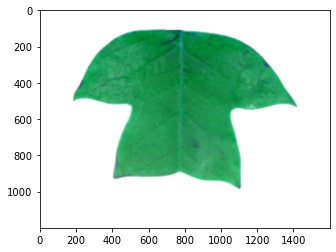

Predicted result:
[26] trident maple
Expected result:
Chinese tulip tree
Plant is not recognized correctly!


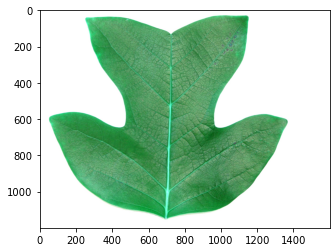

Predicted result:
[26] trident maple
Expected result:
Chinese tulip tree
Plant is not recognized correctly!


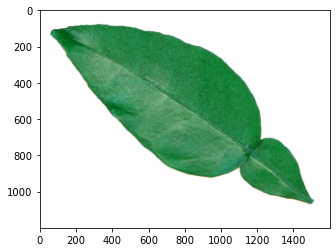

Predicted result:
[11] Japanese cheesewood
Expected result:
tangerine
Plant is not recognized correctly!


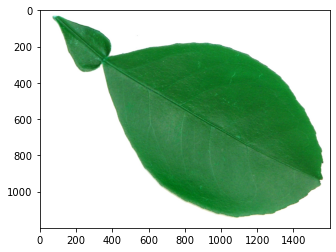

Predicted result:
[31] tangerine
Expected result:
tangerine
Plant is recognized correctly!


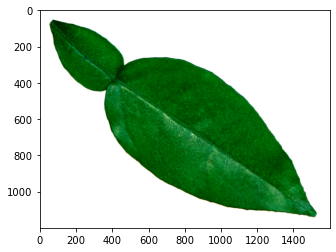

Predicted result:
[31] tangerine
Expected result:
tangerine
Plant is recognized correctly!
Out of 30 pictures, 23 are recognized correctly aka 76.66666666666667 %.


In [14]:
path = "Leaves/test"
files = os.listdir(path)
correct_guesses = 0
images = 0;
for file in files: 
    images = images + 1
    pathPhoto = os.path.join(path,file)
    species = find_species(file)
    img = cv2.imread(pathPhoto)
    plt.imshow(img)
    plt.show()
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)

    leaf_features = preprocess_leaf(original_img)

    X_test = sc_X.transform(leaf_features)
    y_pred = clf.predict(X_test)
    print("Predicted result:")
    print(y_pred, get_name(y_pred[0]))
    print("Expected result:")
    print(get_name(species))
    if  get_name(y_pred[0]) == get_name(species):
        correct_guesses = correct_guesses + 1
        print("Plant is recognized correctly!") 
    else:
        print("Plant is not recognized correctly!")

print("Out of", images, "pictures,", correct_guesses, "are recognized correctly aka", correct_guesses/images*100, "%.");
    